# Geometrical Methods in Machine Learning

## Homework 2

### Manifold learning

Obtain `Extended Yale B` face dataset ([download](https://github.com/oleg-kachan/GMML2023/blob/main/hw2/data/CroppedYale.zip)) which is comprised of $100 \times 100$ pixels images of $38$ persons times $64$ illumination conditions. Resize images to $32 \times 32$ pixels. You can do it using `Pillow` ([link](https://pillow.readthedocs.io/), tested) or any other image processing library of your choice.

1. Using 3 methods of your choice from [scikit-dimension](https://scikit-dimension.readthedocs.io), estimate the intrinsic dimensionality of this data and perform dimensionality reduction to the intrinsic dimension $\hat{d}$ and dimensions $2$ or $3$ for visualization purposes using manifold learning methods of your choice. Compare the performance of different methods, comment on their ideas.

2. Compute NPR (neigborhood preservation ratio, see [seminar 4](https://github.com/oleg-kachan/GMML2022/blob/main/seminar4/seminar4_solution.ipynb)) of algorithms you have used for 2 different values of $d = \{2$ or $3, \hat{d} \}$ and fixed number of nearest neighbors $k$. 

3. Explore the embedding space of dimension $2$ or $3$ for clusters and meaningful interpretations, comment the possible meaning of the new coordinates.

4. Compute and plot persistence diagrams for dimensions $0$ and $1$, conclude whether the dataset have untrivial topology such a several clusters and/or presence of cycles in dimension $1$. If applicable, how can one explain a presence of cycles for the `Extended Yale B` face dataset?

**Grading:** Each subtask is awarded with $1$ point.

In [43]:
from PIL import Image
import glob
from pathlib import Path

y = []
image_list = []
for filename in glob.glob("data/CroppedYale/**/*.pgm"):  # assuming gif
    im = Image.open(filename)
    image_list.append(im)

    label = Path(filename).name
    label = label.split("yaleB")[-1]
    label = label[:2]
    y.append(int(label))

print(len(image_list), type(image_list[0]))
print(len(y), type(y[0]))

2452 <class 'PIL.PpmImagePlugin.PpmImageFile'>
2452 <class 'int'>


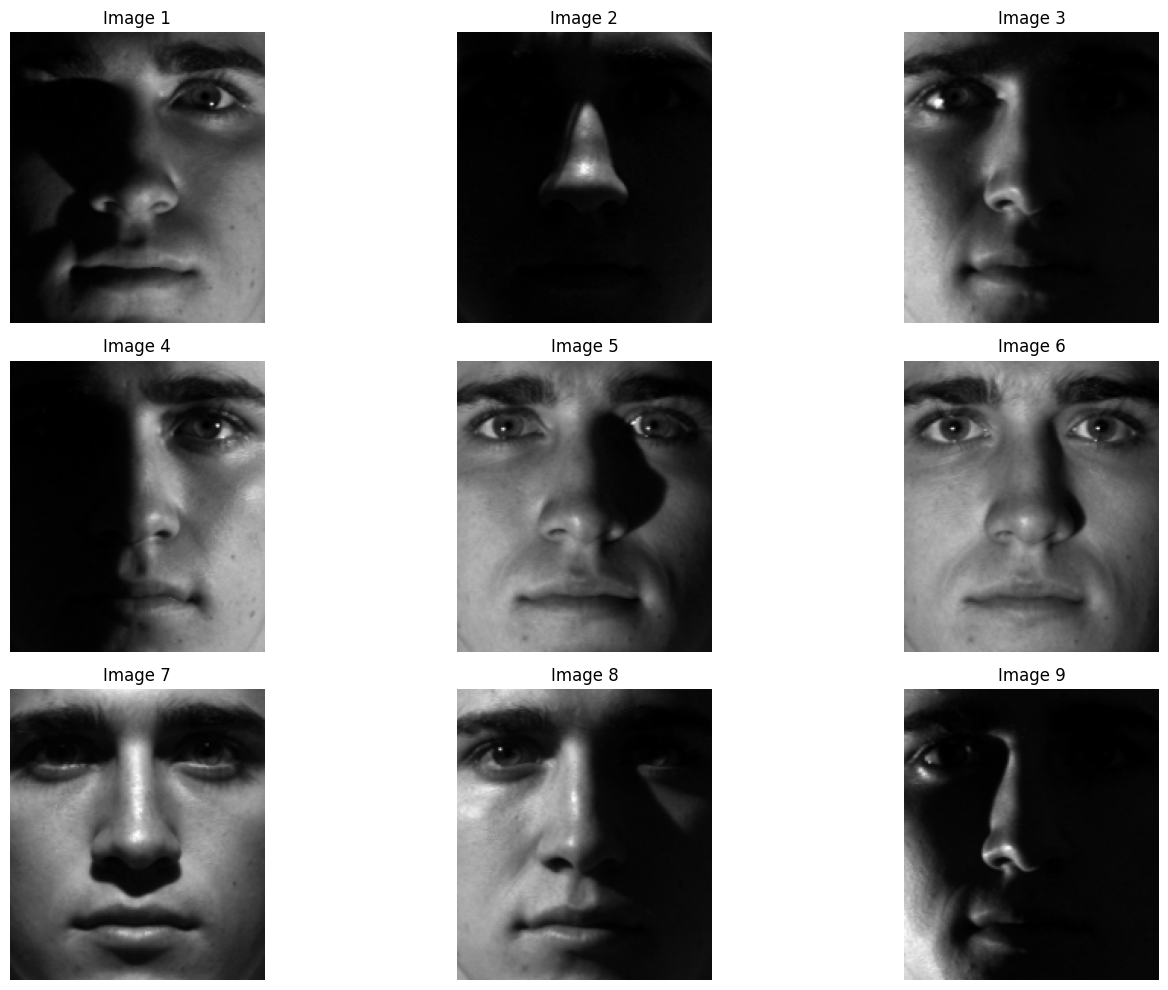

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
# Display first 9 images in a 3x3 grid
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_list[i], cmap="gray")
    plt.title(f"Image {i + 1}")
    plt.axis("off")
plt.tight_layout()

In [45]:
image_list_resized = [im.resize((28, 32)) for im in image_list]

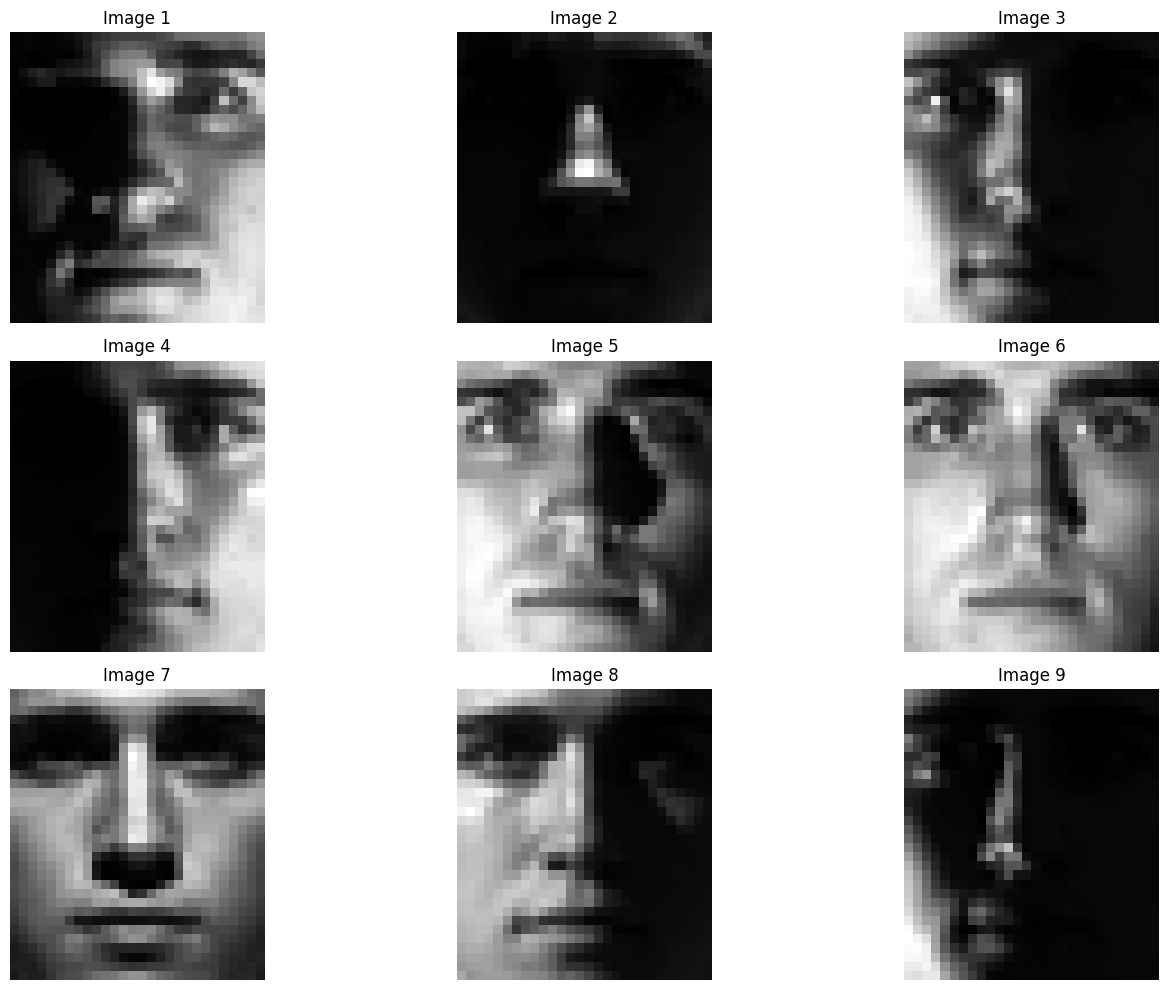

In [46]:
plt.figure(figsize=(15, 10))
# Display first 9 images in a 3x3 grid
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image_list_resized[i], cmap="gray")
    plt.title(f"Image {i + 1}")
    plt.axis("off")
plt.tight_layout()

In [47]:
import numpy as np

image_tensor = np.stack(image_list_resized)
image_tensor.shape

(2452, 32, 28)

In [48]:
image_tensor = image_tensor.reshape(image_tensor.shape[0], -1)
image_tensor.shape

(2452, 896)

In [49]:
import skdim

pca_d = skdim.id.lPCA().fit_transform(image_tensor)
mom_d = skdim.id.MOM().fit_transform(image_tensor)
knn_d = skdim.id.KNN().fit_transform(image_tensor)

print(f"Estimated dimensions: lPCA = {pca_d}, MOM = {mom_d}, KNN = {knn_d}")


Estimated dimensions: lPCA = 4, MOM = 7.782035720649095, KNN = 4


In [50]:
from sklearn.neighbors import NearestNeighbors


def NPR(X, Z, k=15):
    _, neighborhood_X = NearestNeighbors(n_neighbors=k).fit(X).kneighbors(X)
    _, neighborhood_Z = NearestNeighbors(n_neighbors=k).fit(Z).kneighbors(Z)

    n = X.shape[0]
    npr = 0
    for i in range(n):
        npr += np.intersect1d(neighborhood_X[i], neighborhood_Z[i]).shape[0]

    return npr / (k * n)

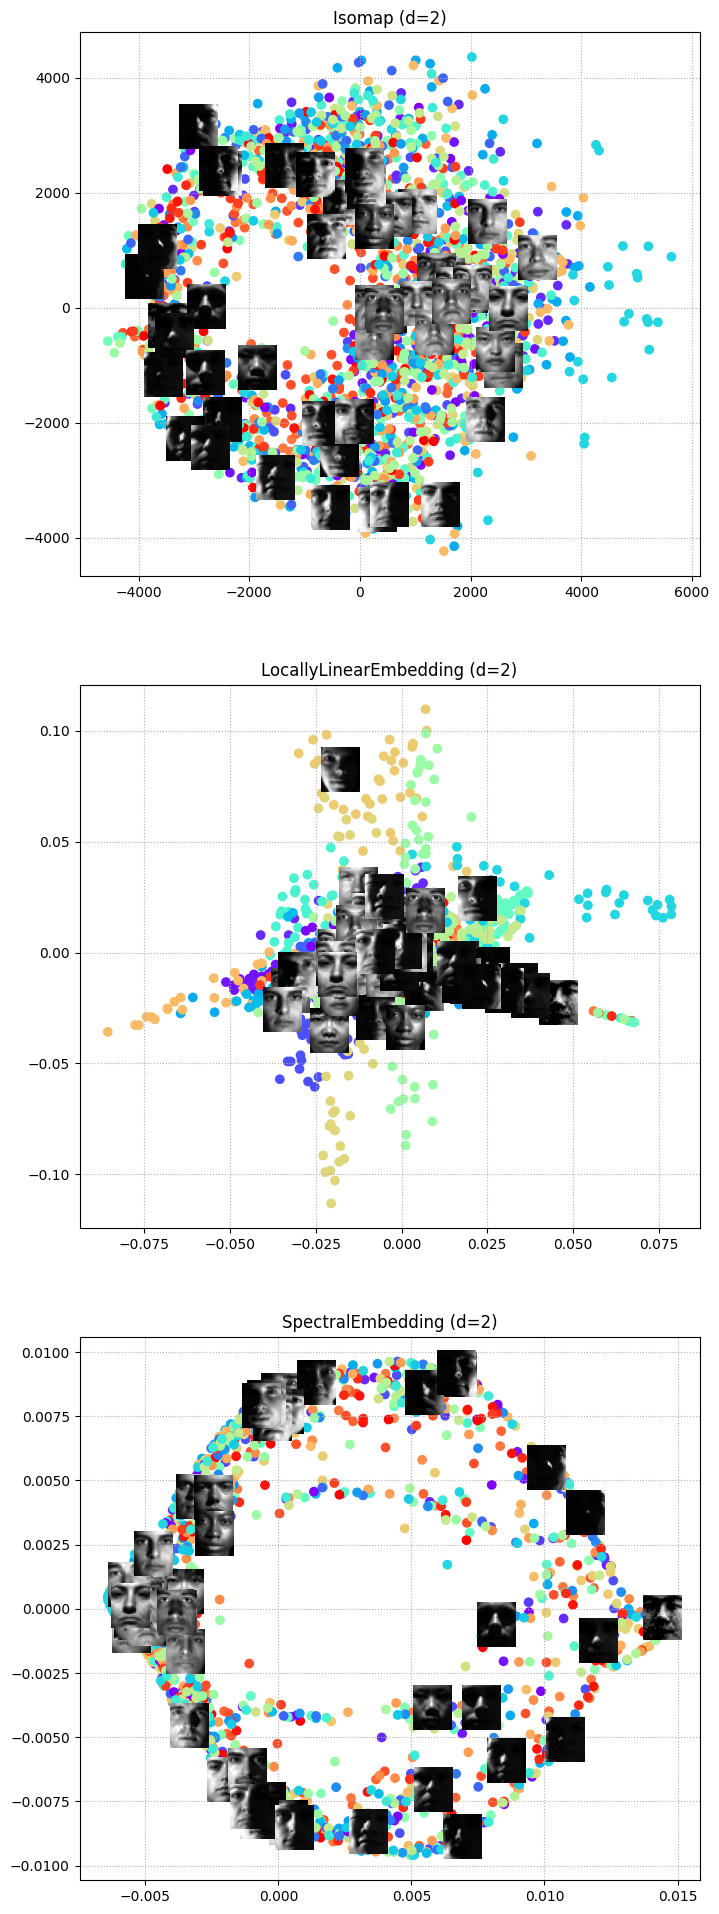

In [51]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding
from matplotlib import offsetbox
from ripser import ripser

k = 15

dimensions = [4, 8, 2, 3]
models = {"Isomap": Isomap, "LocallyLinearEmbedding": LocallyLinearEmbedding, "SpectralEmbedding": SpectralEmbedding}

nprs = []
diagrams = []

fig = plt.figure(figsize=(8, len(models) * 8))
axes = fig.subplots(nrows=len(models), ncols=1)

for i, (model_name, Model) in enumerate(models.items()):
    for d in dimensions:
        model = Model(n_components=d, n_neighbors=15)
        reduced = model.fit_transform(image_tensor)

        npr = NPR(image_tensor, reduced, k)
        nprs.append((model_name, d, npr))

        if d == 2:
            diagrams_item = ripser(reduced, maxdim=1)["dgms"]
            diagrams.append((model_name, diagrams_item))

            axes[i].grid(linestyle="dotted")
            axes[i].scatter(reduced[:, 0], reduced[:, 1], c=y, cmap=plt.cm.rainbow)
            axes[i].set_title(f"{model_name} (d={d})")

            for j in range(0, image_tensor.shape[0], 50):
                pic = offsetbox.OffsetImage(image_tensor[j].reshape((32, 28)), cmap="gray", zoom=1)
                box = offsetbox.AnnotationBbox(
                    pic,
                    reduced[j],
                    frameon=False,
                )
                axes[i].add_artist(box)

plt.show()


As we can see with all methods the most prominent features are:
- Overall lighting conditions. Dark and light pictures tend to be grouped together by all methods;
- Lighting direction. The second axis reflect the lighting direction highlighting faces from different angles;
- We also tend to see groupings by the similar bone structure and amount of hair.

In [52]:
print(f"NPR results:\n{'model':<24} | d | NPR ratio\n")
print("------------------------------------------\n")
for model_name, d, npr in nprs:
    print(f"{model_name:<24} | {d} | {npr}\n")

NPR results:
model                    | d | NPR ratio

------------------------------------------

Isomap                   | 4 | 0.4418162044589451

Isomap                   | 8 | 0.5599238716693855

Isomap                   | 2 | 0.24627514953779228

Isomap                   | 3 | 0.3564709081022295

LocallyLinearEmbedding   | 4 | 0.3289559543230016

LocallyLinearEmbedding   | 8 | 0.40538336052202284

LocallyLinearEmbedding   | 2 | 0.18039695486677543

LocallyLinearEmbedding   | 3 | 0.2730288200108755

SpectralEmbedding        | 4 | 0.32765089722675367

SpectralEmbedding        | 8 | 0.43085916258836326

SpectralEmbedding        | 2 | 0.29007612833061447

SpectralEmbedding        | 3 | 0.30943447525829254



**Comment:**

- Isomap preserves global structure by using geodesic distances. It also performs best across all dimensions.
- LocallyLinearEmbedding focuses on local relationships only.
- SpectralEmbedding balances local and global structure using graph laplacians.

The superiority of Isomap suggests that global structures in the pictures (such as light?) dominate.

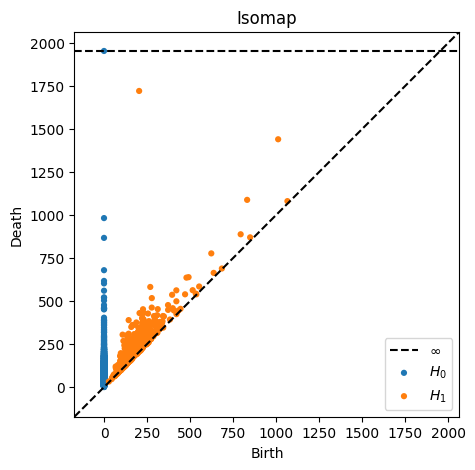

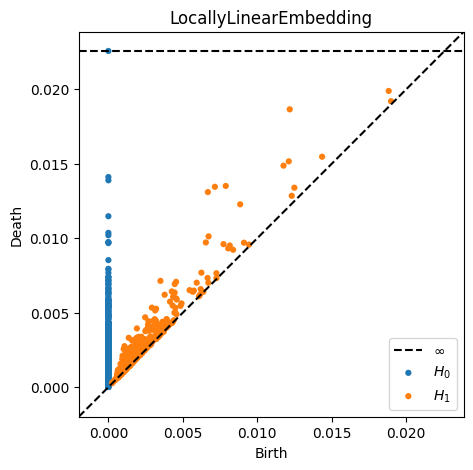

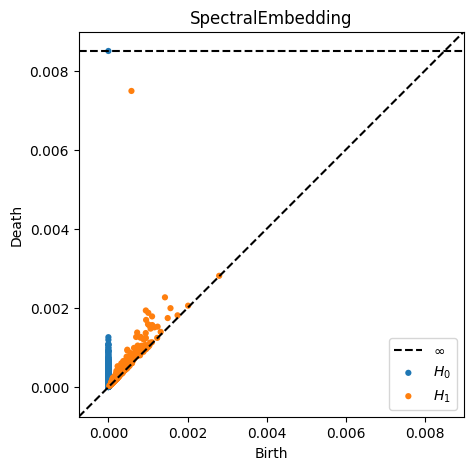

In [54]:
from persim import plot_diagrams
import matplotlib.pyplot as plt

for model_name, diagram in diagrams:
    plt.figure(figsize=(10, 5))
    plot_diagrams(diagram, show=True, title=model_name)

**Comment:**

H0: all methods show several blue points away from the diagonal indicating a multi-cluster structure in the data. This confirms the presence of groupings which correspond to the different people in the dataset.

H1: all methods show orange points significantly away from the diagonal indicating the presence of cycles. This confirms the dataset has non-trivial topology with persistent loops in the embedding space.

Cycles can be explained by:
- Light: the source moves around the subject;
- Facial expressions: subtle changes from one face to another;
- Poses, maybe?

#### Grading:

- 8/10 points are awarded for completing all the tasks and giving proper answers to questions.
- 2/10 points are awarded for the quality of reporting, be sure to give explanations and comments to your solutions.
- +1 extra point may be awarded for the extra work performed, be creative.